# Arctic-EDS data preparation - Design freezing and thawing index

## Objectives

This notebook will execute the necessary preprocessing of data prior to being ingested into Rasdaman as coverages to support the "Design" versions of the freezing and thawing indices. Thus, the scope of this notebook will cover two "plates" in the original Environmental Atlas of Alaska.

### Plates
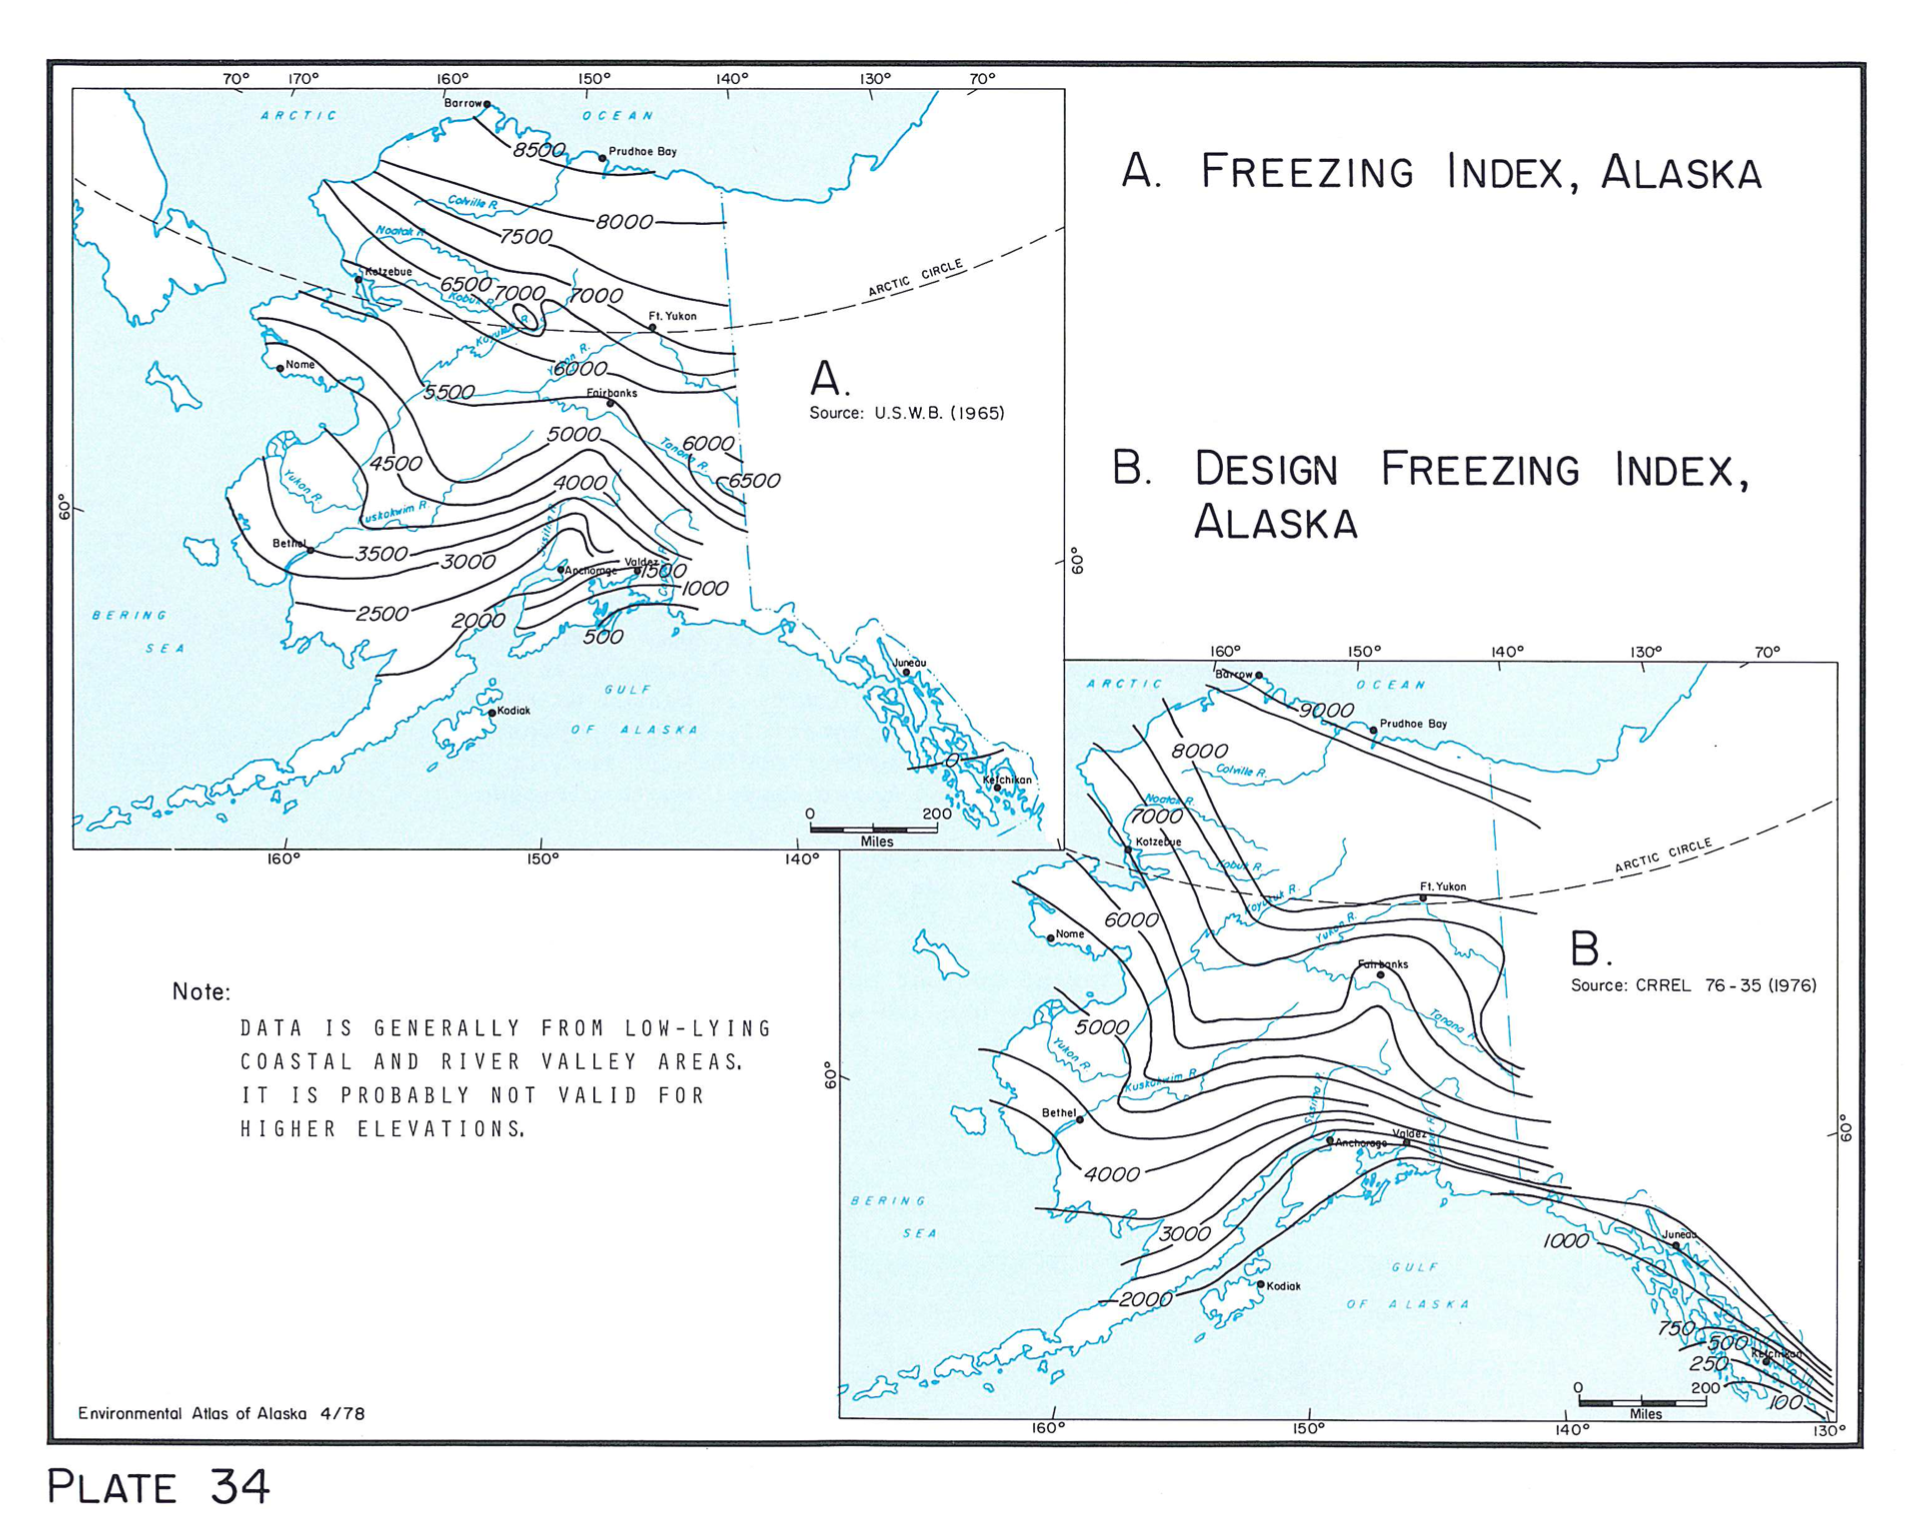

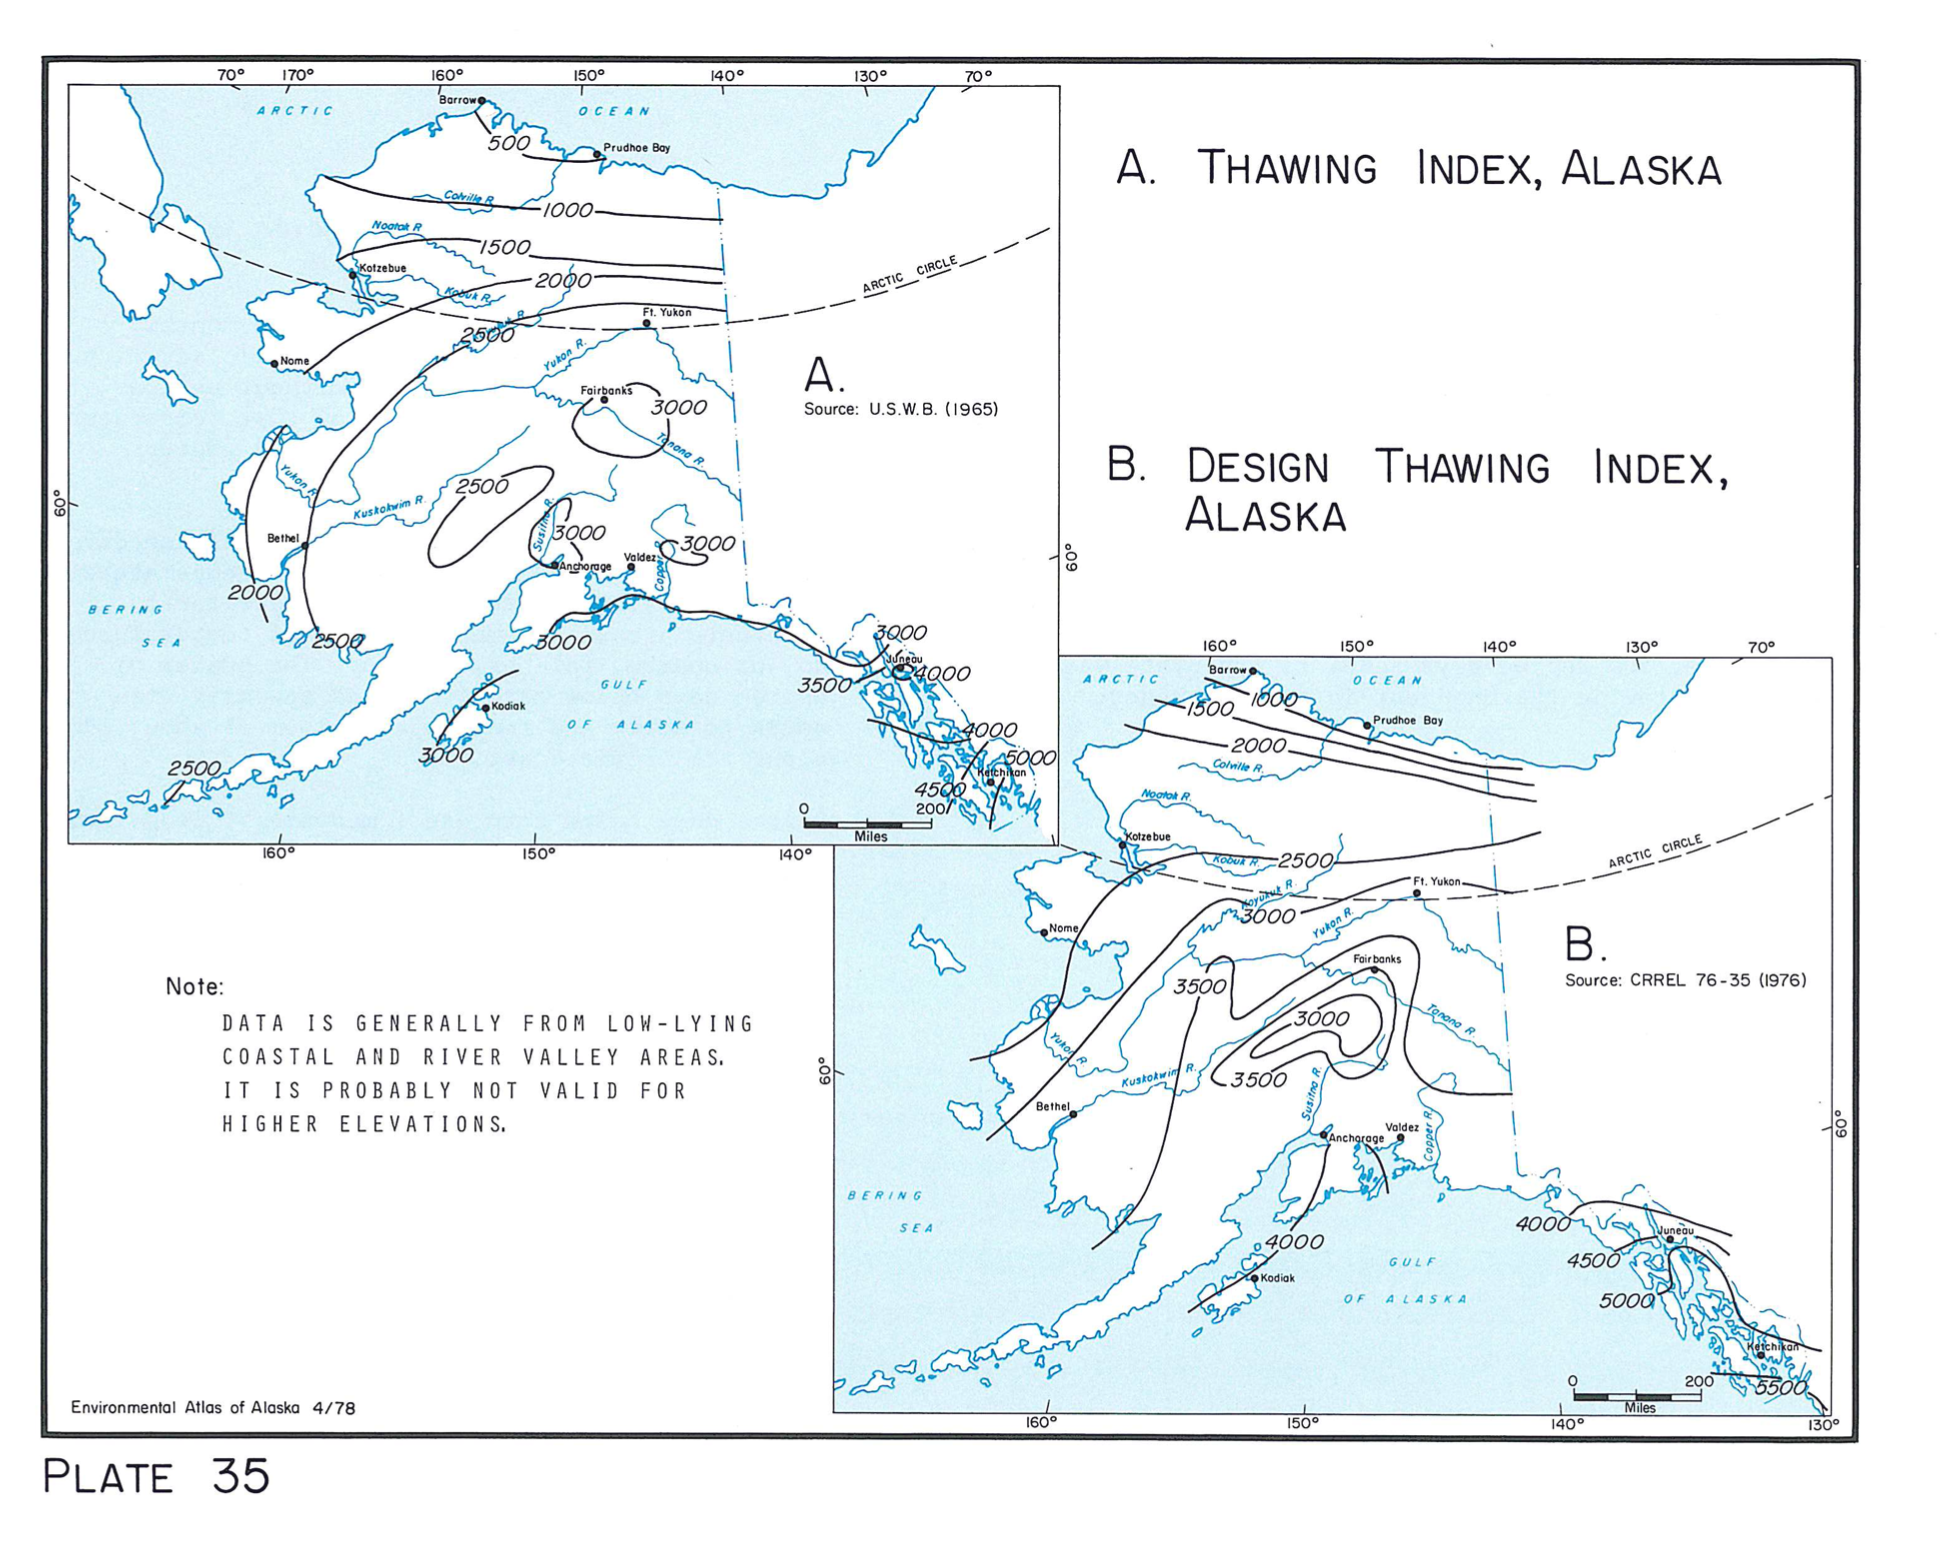

To create a modern versions of these plates, we will want two coverages in Rasdaman - one for design thawing index, and one for design freezing index.

## Replacement Data

The replacement data for both of these new coverages will be the 20km WRF-downscaled climate data:

CKAN entry: [Historical and Projected Dynamically Downscaled Climate Data for the State of Alaska and surrounding regions at 20km spatial resolution and hourly temporal resolution](http://ckan.snap.uaf.edu/dataset/historical-and-projected-dynamically-downscaled-climate-data-for-the-state-of-alaska-and-surrou)

This dataset has daily mean temperature values and has been used to calculate the requisite thawing and freezing index datasets. See [the degree day processing notebook](../degree_days/dd_preprocessing.ipynb) for more information on this dataset.

## Processing

The processing strategy will be to simply summarize the existing thawing and freezing index datasets to obtain the design thawing and design freezing index datasets. These are traditionally computed by taking the mean of indices for the 3 warmest years and 3 coldest years, respectively. This is what we will do for the available historical data, 1980-2009. For projections, we will do the same for two future periods, 2040-2069, and 2070-2099 (as a starting point until we know better :))

Start with setting the paths to where the thawing and freezing index datasets reside, preferably in your scratch space on Atlas:

In [1]:
freeze_dir = "/atlas_scratch/kmredilla/arctic_eds/freezing_index"
thaw_dir = "/atlas_scratch/kmredilla/arctic_eds/thawing_index"

Make new directories for outputs in the parent dir:

In [2]:
from pathlib import Path


freeze_dir = Path(freeze_dir)
thaw_dir = Path(thaw_dir)

out_dir = Path("/atlas_scratch/cparr4/arcticeds/")

dfreeze_dir = out_dir.joinpath("design_freezing_index")
dfreeze_dir.mkdir(exist_ok=True)
dthaw_dir = out_dir.joinpath("design_thawing_index")
dthaw_dir.mkdir(exist_ok=True)

Define a function to get the three highest from a sorted 1D array:

In [1]:
import numpy as np


def avg_extremes(arr, low=True):
    """Freezing and thawing indices are computed from cumulative, positive
    sums of degree days beyond a certain temperature threshold. To get the three
    most "intense" (coldest or warmest) years we will sort all available index values
    and get the top three to use in the mean computation of the design value."""
    # if first element is np.nan, then all should be
    if np.isnan(arr[0]):
        return np.nan
    # otherwise, sort and return avg
    arr = np.sort(arr)
    return arr[-3:].mean()

Define a function to read a list of (30) yearly files and choose the three coldest or warmest ones by pixel, compute the average of those three, and write the result to an output directory:

In [2]:
import rasterio as rio


def read_tif(fp):
    """Helper function to read in GeoTIFFs and apply"""
    with rio.open(fp) as src:
        arr = src.read(1).astype(np.float32)
    arr[arr == src.meta["nodata"]] = np.nan
    
    return arr


def compute_design_index(fps, profile, out_fp):
    arr = np.array([read_tif(fp) for fp in fps])
    mean_arr = np.round(np.apply_along_axis(avg_extremes, 0, arr))
    mean_arr[np.isnan(mean_arr)] = profile["nodata"]
    
    with rio.open(out_fp, "w", **profile) as dst:
        dst.write(mean_arr, 1)

Get the rasterio profile dict for writing new GeoTIFFs - will be identical to one of the input files:

In [5]:
with rio.open(list(freeze_dir.glob("*.tif"))[0]) as src:
    profile = src.profile

### Design freezing index

Compute the design freezing index for the all time periods, models and eras. 

#### Historical:

In [6]:
fps = [
    freeze_dir.joinpath(f"freezing_index_ERA-Interim_{year}.tif")
    for year in np.arange(1980, 2010)
]
out_fp = dfreeze_dir.joinpath(f"design_freezing_index_ERA-Interim_1980-2009.tif")

compute_design_index(fps, profile, out_fp)    

#### Projected:

Iterate over models and future eras (four combinations):

In [7]:
eras = ["2040-2069", "2070-2099"]
models = ["GFDL-CM3", "NCAR-CCSM4"]

for era in eras:
    for model in models:
        start_year, end_year = era.split("-")
        end_year = int(end_year) + 1
        fps = [
            freeze_dir.joinpath(f"freezing_index_{model}_{year}.tif")
            for year in np.arange(int(start_year), end_year)
        ]
        out_fp = dfreeze_dir.joinpath(f"design_freezing_index_{model}_{era}.tif")
        compute_design_index(fps, profile, out_fp)

### Design thawing index

Compute the design thawing index for the all time periods, models and eras. Same code as above with some pathing changes and a flip of a switch.

#### Historical:

In [8]:
fps = [
    thaw_dir.joinpath(f"thawing_index_ERA-Interim_{year}.tif")
    for year in np.arange(1980, 2010)
]
out_fp = dthaw_dir.joinpath(f"design_thawing_index_ERA-Interim_1980-2009.tif")

compute_design_index(fps, profile, out_fp)    

#### Projected:

Iterate over models and future eras (four combinations):

In [9]:
for era in eras:
    for model in models:
        start_year, end_year = era.split("-")
        end_year = int(end_year) + 1
        fps = [
            thaw_dir.joinpath(f"thawing_index_{model}_{year}.tif")
            for year in np.arange(int(start_year), end_year)
        ]
        out_fp = dthaw_dir.joinpath(f"design_thawing_index_{model}_{era}.tif")
        compute_design_index(fps, profile, out_fp)

## Quality

Verify we have the expected number of new GeoTIFFs in both design freezing and thawing directories (5) and check file sizes:

In [10]:
out_fps = sorted(list(dfreeze_dir.glob("*.tif")))
print(f"Number of files: {len(out_fps)}")

sizes = [round(fp.stat().st_size / 1e3) for fp in out_fps]
print(f"Unique file sizes (KB): {np.unique(sizes, return_counts=True)}")

Number of files: 5
Unique file sizes (KB): (array([11, 12, 13]), array([1, 3, 1]))


In [11]:
out_fps = sorted(list(dthaw_dir.glob("*.tif")))
print(f"Number of files: {len(out_fps)}")

sizes = [round(fp.stat().st_size / 1e3) for fp in out_fps]
print(f"Unique file sizes (KB): {np.unique(sizes, return_counts=True)}")

Number of files: 5
Unique file sizes (KB): (array([13]), array([5]))


### Maps and histograms

Since these are small datasets, we can visualize all of them easily.

#### Design freezing index

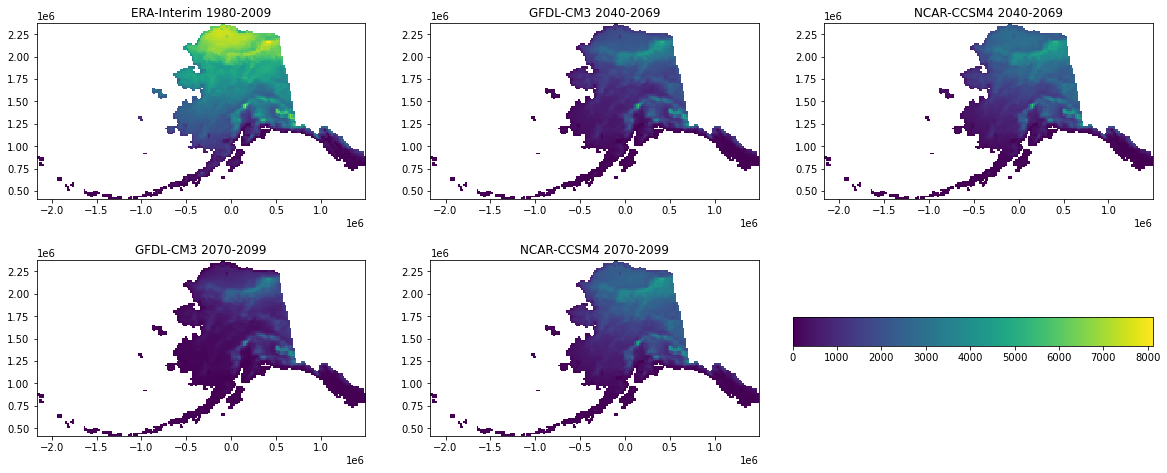

In [12]:
import matplotlib.pyplot as plt
from rasterio.plot import show


def plot_maps(out_dir):
    fig, axs = plt.subplots(2, 3, figsize=(20, 8))
    out_fps = list(out_dir.glob("*.tif"))
    arrs = []
    titles = []
    for ax, fp in zip(axs.flatten()[:-1], out_fps):
        with rio.open(fp) as src:
            show(src, ax=ax, interpolation="none", vmin=0, vmax=8108)
            arrs.append(src.read(1))
        title = " ".join(fp.name.split(".")[0].split("_")[-2:])
        ax.set_title(title)
        titles.append(title)
        
    fig.delaxes(axs[-1, -1])
    cbar_ax = fig.add_axes([0.65, 0.3, 0.25, 0.05])
    fig.colorbar(axs[0,0].images[0], cax=cbar_ax, orientation="horizontal")

    plt.show()
    
    return arrs, titles


arrs, titles = plot_maps(dfreeze_dir)

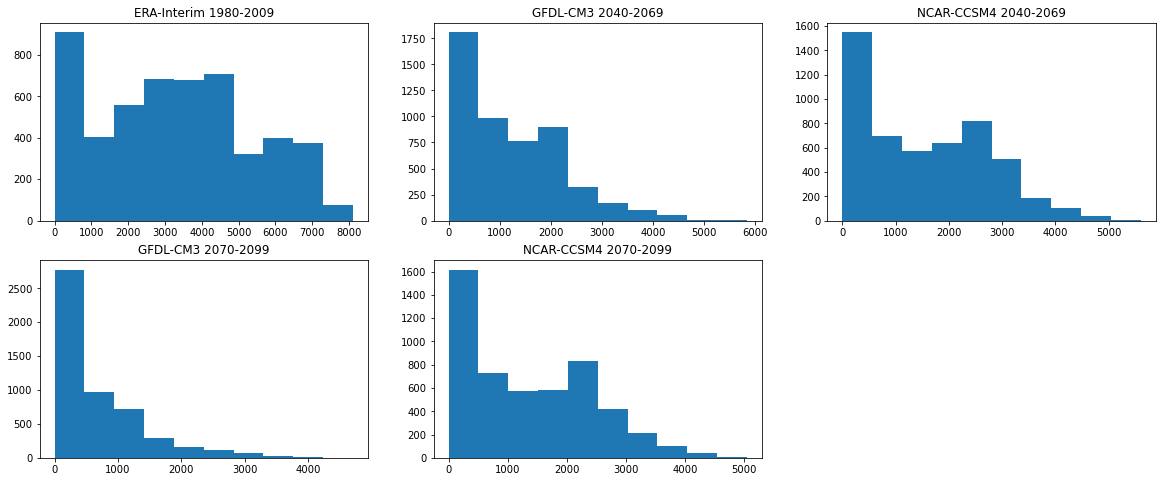

In [13]:
def plot_histograms(arrs, titles):
    fig, axs = plt.subplots(2, 3, figsize=(20, 8))
    for ax, arr, title in zip(axs.flatten(), arrs, titles):
        arr = arr.flatten()
        arr = arr[arr != -9999]
        ax.hist(arr)
        ax.set_title(title)
        
    fig.delaxes(axs[-1, -1])

    plt.show()

    
plot_histograms(arrs, titles)

#### Design thawing index

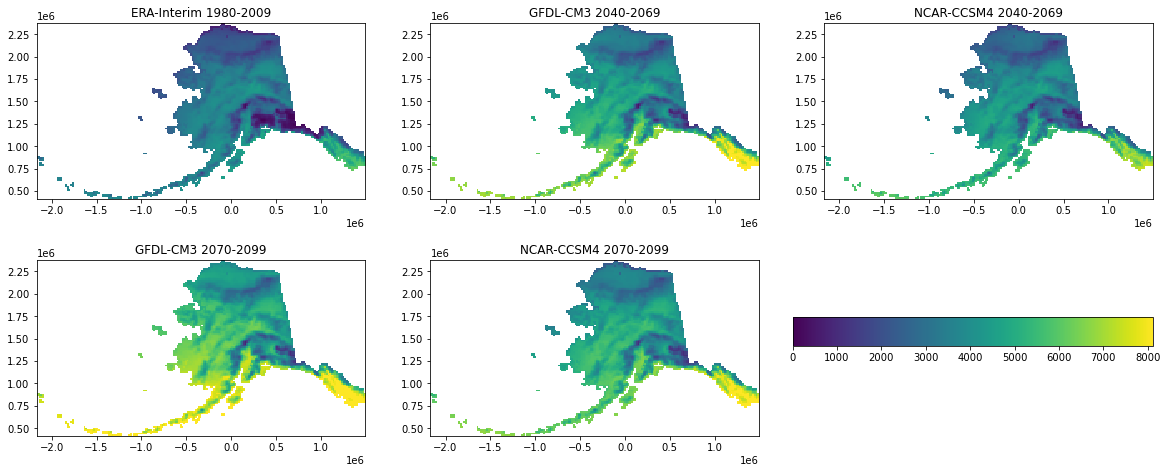

In [14]:
arrs, titles = plot_maps(dthaw_dir)

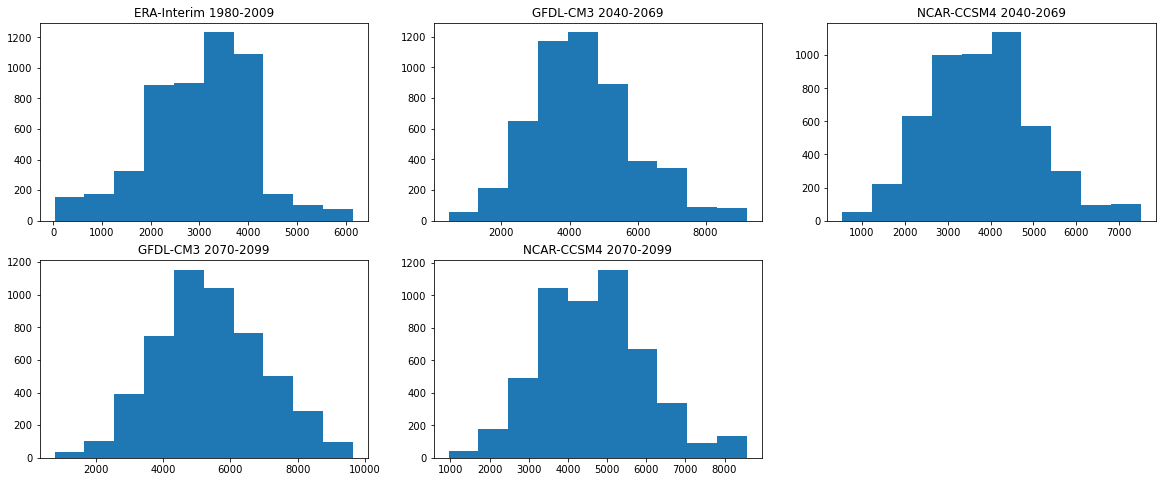

In [15]:
plot_histograms(arrs, titles)

OK at this point these data are basically ready for ingest! The data now need to be moved to a Rasdaman server (Apollo, Zeus).

```sh
scp -r /atlas_scratch/cparr4/arcticeds/design_freezing_index cparr4@apollo.snap.uaf.edu:  
scp -r /atlas_scratch/cparr4/arcticeds/design_thawing_index cparr4@apollo.snap.uaf.edu: 
```